In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.distributions.empirical_distribution import ECDF
from functools import partial

# Data Exploration
This notebook is created for visulalising the data and try out different ways to fit copula.


## Data
Three datasets. 
1. Bitcoin Future from CME
    - Downloaded from Bloomberg
    - From 2017-12-15 to 2020-09-04
    - Consist of BTCU0, BTCM0, BTCH0, BTCZ9, BTCU19, BTCM19, BTCH19, BTCZ18, and BTCU18. 
    - OHLC and volume data
    - Daily data

2. BRR 
    - BRR is the reference rate of Bitcoin used by the Bitcoin future
    - Same period of time of Bitcoin future
    - Also from Bloomberg
    
3. CRIX
    - Download from CRIX http://data.thecrix.de/data/crix.json
    - Daily data
    - from 2014-07-31 to 2020-09-14
    - Weights of constituents change across time; Dataset does not include this;


## Using Scipy.stats.kendalltau
Using scipy is the easiest way to get kendall's tau. (https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.kendalltau.html)

According to the documentation of Scipy, the function return the 1945 "tau-b" version of Kendall's tau. 

In [53]:
future = pd.read_excel("../data/Crypto related/BTC CME Future.xlsx")
future.head()

,Date,Last Price,Open Price,High Price,Low Price,BTC1 Curncy - Volume
0,2020-09-04,10480,10730.0,10740.0,10355.0,13711.0
1,2020-09-03,10720,11710.0,11710.0,10840.0,15412.0
2,2020-09-02,11460,12405.0,12405.0,11530.0,17210.0
3,2020-09-01,12075,12050.0,12450.0,12050.0,8919.0
4,2020-08-31,11835,11735.0,11915.0,11705.0,4865.0


In [87]:
future.loc[:,'Date'] = pd.to_datetime(future.loc[:,'Date'])
future = future.loc[:,['Date','Last Price']]
# future.loc[:-1,'log return'] = np.log(future.loc[:,'Last Price'].values[:-1]/future.loc[:,'Last Price'].values[1:])
future.loc[:,'log return'] = np.zeros(len(future))
future.loc[:,'log return'] = np.log(future.loc[:,'Last Price']/future.loc[:,'Last Price'].shift(-1))
future.loc[1:,'log return'] = np.log(future.loc[:,'Last Price'].values[1:]/future.loc[:,'Last Price'].values[:-1])
f = future.loc[:,['Date', 'log return']]

In [84]:
brr.head()

,Date,Last Price,Open Price,High Price,Low Price,BRR Index - Volume,log return
0,2020-09-04,10273.83,10273.83,10273.83,10273.83,NaN,-0.056452
1,2020-09-03,10870.49,10870.49,10870.49,10870.49,NaN,-0.040962
2,2020-09-02,11325.01,11325.01,11325.01,11325.01,NaN,-0.046365
3,2020-09-01,11862.46,11862.46,11862.46,11862.46,NaN,0.012073
4,2020-08-31,11720.10,11720.10,11720.10,11720.10,NaN,0.008895


In [89]:
brr = pd.read_excel("../data/Crypto related/BRR index.xlsx")
brr.loc[:,'Date'] = pd.to_datetime(brr.loc[:,'Date'])
brr.loc[:,'log return'] = np.log(brr.loc[:,'Last Price']/brr.loc[:,'Last Price'].shift(-1))
brr_future = pd.merge(left=brr, right=f, how='inner', left_on='Date', right_on='Date', suffixes=(' brr',' future'))
brr_future.head()

,Date,Last Price,Open Price,High Price,Low Price,BRR Index - Volume,log return brr,log return future
0,2020-09-04,10273.83,10273.83,10273.83,10273.83,NaN,-0.056452,-0.022642
1,2020-09-03,10870.49,10870.49,10870.49,10870.49,NaN,-0.040962,0.022642
2,2020-09-02,11325.01,11325.01,11325.01,11325.01,NaN,-0.046365,0.066752
3,2020-09-01,11862.46,11862.46,11862.46,11862.46,NaN,0.012073,0.052274
4,2020-08-31,11720.10,11720.10,11720.10,11720.10,NaN,0.008895,-0.020076


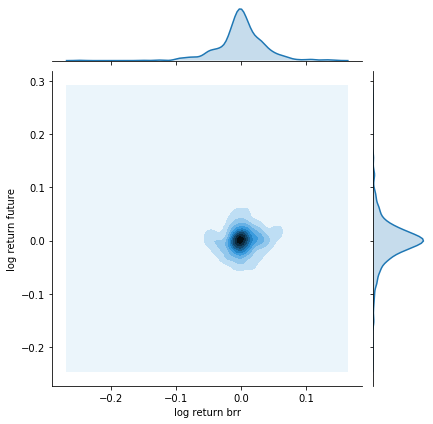

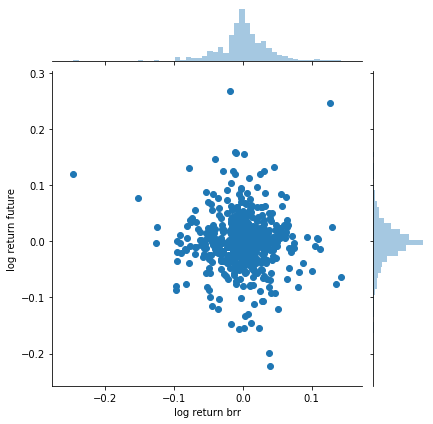

In [91]:
sns.jointplot(data=brr_future, x="log return brr", y="log return future", kind='kde')
sns.jointplot(data=brr_future, x="log return brr", y="log return future")

In [93]:
tau = stats.kendalltau(brr_future.iloc[1:,-1],brr_future.iloc[1:,-2])

Text(0.5, 1.0, 'Bitcoin Future Log Return CDFs')

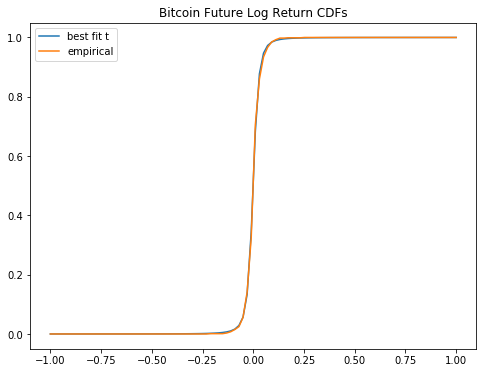

In [22]:
f_df, f_loc, f_scale = stats.t.fit(brr.iloc[1:,-1])
x = np.linspace(-1,1,100)
y = stats.t(loc=f_loc, scale=f_scale, df=f_df).cdf(x)
ecdf_f = ECDF(brr.iloc[1:,-1])
plt.figure(figsize=(8,6))
plt.plot(x,y, label='best fit t')
plt.plot(x, ecdf_f(x), label='empirical')
plt.legend()
plt.title("Bitcoin Future Log Return CDFs")

Text(0.5, 1.0, 'BRR Log Return CDFs')

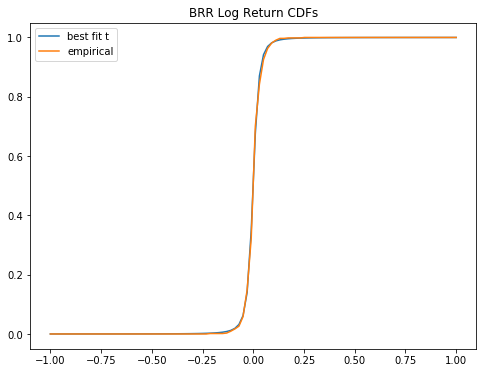

In [21]:
b_df, b_loc, b_scale = stats.t.fit(brr_future.iloc[1:,-2])
x = np.linspace(-1,1,100)
y = stats.t(loc=b_loc, scale=b_scale, df=b_df).cdf(x)
ecdf_b = ECDF(brr_future.iloc[1:,-2])
plt.figure(figsize=(8,6))
plt.plot(x,y, label='best fit t')
plt.plot(x, ecdf_b(x), label='empirical')
plt.legend()
plt.title("BRR Log Return CDFs")

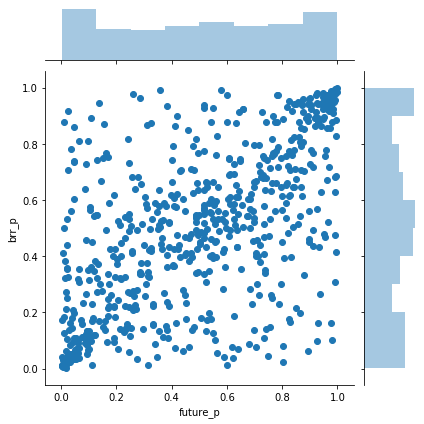

In [25]:
future_t = stats.t(loc=f_loc, scale=f_scale, df=f_df)
brr_t   = stats.t(loc=b_loc, scale=b_scale, df=b_df)
x = future_t.cdf(brr_future.iloc[1:,-1])
y = brr_t.cdf(brr_future.iloc[1:,-2])
toplot = pd.DataFrame([x,y]).T
toplot.columns = ['future_p', 'brr_p']
sns.jointplot(data=toplot, x='future_p', y='brr_p')

In [26]:
def copula_density_Clayton(u, v, theta):
    A = (1+theta)
    B = (u*v)**(-1-theta)
    C = (-1+(u**-theta)+(v**-theta))**(-2-(1/theta))
    return np.nan_to_num(A*B*C)

def f_Z_2(y1, nS, nF, Law_RS, Law_RF, theta):
    N = 100000
    u2 = np.linspace(0,1,N)
    a = (y1-nF*Law_RF.ppf(u2))/nS
    A = copula_density_Clayton(Law_RS.cdf(a), u2, theta)
    B = Law_RS.pdf(a)
    m = A*B
    return np.sum(((m[1:]+m[:-1])*1/N)/2)/np.abs(nS)

In [27]:
nS = 1
nF_arr = [-0.90,-0.95, -1, -1.05,-1.10]
Law_RS = brr_t
Law_RF = future_t
ny = 100
y1 = np.linspace(-1,1,ny)

crix_future_result= []

for nF in nF_arr:
    theta  = 2*tau[0]/(1-tau[0])
    fn = partial(f_Z_2, nS=nS, nF=nF, Law_RS= Law_RS, Law_RF=Law_RF, theta=theta)
    v_fn = np.vectorize(fn)
    RH_density = v_fn(y1) 
    crix_future_result.append(RH_density)
    print(nF)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


-0.9
-0.95
-1
-1.05
-1.1


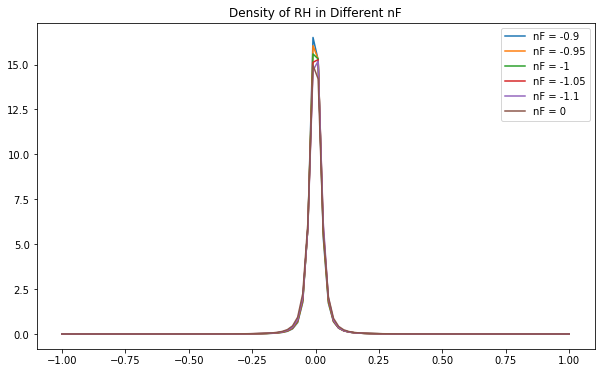

In [42]:
plt.figure(figsize=(10,6))
plt.title('Density of RH in Different nF')
for i, nF in enumerate(nF_arr):
    plt.plot(y1, crix_future_result[i], label='nF = %s'%nF)
plt.plot(y1, Law_RS.pdf(y1), label='nF = 0')
plt.legend()

In [44]:
r = requests.get('http://data.thecrix.de/data/crix.json')
crix = pd.DataFrame(r.json())
crix.loc[:,'date'] = pd.to_datetime(crix.loc[:,'date'])
crix.loc[1:,'log return'] = np.log(crix.price.values[1:]/crix.price.values[:-1])

In [45]:
crix.head()

,date,price,log return
0,2014-07-31,1000.000000,NaN
1,2014-08-01,1018.202717,0.018039
2,2014-08-02,1008.772389,-0.009305
3,2014-08-03,1004.416500,-0.004327
4,2014-08-04,1004.984138,0.000565


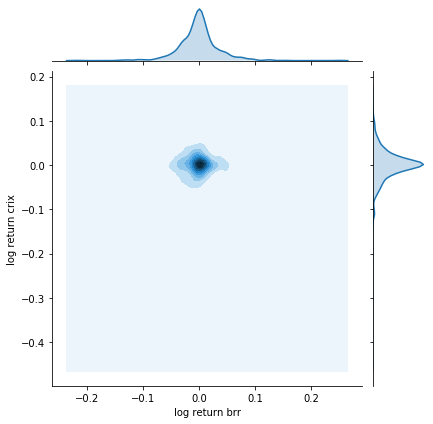

In [51]:
crix_brr = pd.merge(left=crix, right=brr, how='inner', left_on='date', right_on='Date', suffixes=(' crix',' brr'))

In [ ]:
crix_brr.iloc

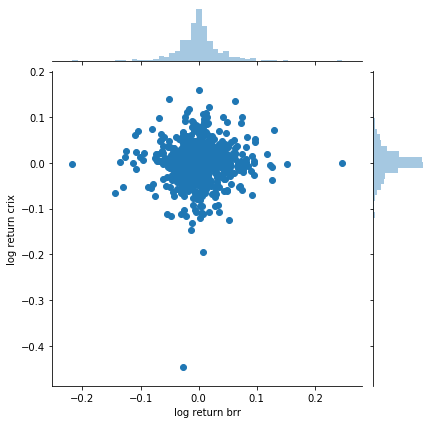

In [52]:
sns.jointplot(data=crix_brr, x="log return brr", y="log return crix")

## Standard Procedure of Fitting a Copula?
